# This notebook will contain the model training process, evaluation, and hyperparameter tuning:

- Model selection using H2O AutoML

- Splitting data into train/test sets

- Model training, evaluation, and cross-validation

- Hyperparameter tuning

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import h2o
from h2o.automl import H2OAutoML

### Input 02-notebook file

In [2]:
path = '../data/cleaned/heart_2022_cleaned_02.csv'

In [3]:
# read data
df = pd.read_csv(path ,sep=',',encoding='utf-8')
df.sample(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,WeightInKilograms^2,WeightInKilograms BMI,WeightInKilograms BMI_Weight_Interaction,WeightInKilograms BMI_Height_Interaction,BMI^2,BMI BMI_Weight_Interaction,BMI BMI_Height_Interaction,BMI_Weight_Interaction^2,BMI_Weight_Interaction BMI_Height_Interaction,BMI_Height_Interaction^2
41274,CO,1,4,-0.258523,1.890823,2,1,0.656772,0,0,...,5266.4049,1666.2072,120916.656504,2965.848816,527.1616,38256.117312,938.347648,2.776246e+06,68095.888815,1670.258813
58831,DE,1,3,1.256021,-0.515488,3,1,-0.687687,0,1,...,16829.8729,5324.1192,690697.983816,9476.932176,1684.2816,218501.851968,2998.021248,2.834625e+07,388933.296503,5336.477821
292534,OH,0,1,0.207490,3.093979,3,0,-0.687687,1,0,...,4690.8801,1572.5304,107702.607096,2720.477592,527.1616,36105.297984,911.989568,2.472852e+06,62462.165512,1577.741953
159628,MD,1,2,-0.491530,-0.515488,3,1,0.656772,0,0,...,11752.7281,3717.3789,403001.046549,6616.934442,1175.8041,127468.922481,2092.931298,1.381891e+07,226894.682016,3725.417710
48259,CT,1,3,-0.491530,-0.515488,3,1,-0.015457,0,0,...,8230.1184,2530.1808,229538.002176,4554.325440,777.8521,70566.742512,1400.133780,6.401815e+06,127020.136522,2520.240804


In [4]:
output_path = '../data/cleaned/dtype.csv'
df.dtypes.to_csv(output_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442067 entries, 0 to 442066
Data columns (total 88 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   State                                          442067 non-null  object 
 1   Sex                                            442067 non-null  int64  
 2   GeneralHealth                                  442067 non-null  int64  
 3   PhysicalHealthDays                             442067 non-null  float64
 4   MentalHealthDays                               442067 non-null  float64
 5   LastCheckupTime                                442067 non-null  int64  
 6   PhysicalActivities                             442067 non-null  int64  
 7   SleepHours                                     442067 non-null  float64
 8   RemovedTeeth                                   442067 non-null  int64  
 9   HadHeartAttack                       

### H2O AutoML to Select and Train the Best Mode

#### Splitting data into train/test sets


In [ ]:
# Start H2O cluster
h2o.init()
# Convert data into H2O frame (required by H2O)
h2o_df = h2o.H2OFrame(df)
h2o_df['HadHeartAttack'] = h2o_df['HadHeartAttack'].asfactor()

# Specify the target column
target = 'HadHeartAttack'

# Define the feature columns
features = [col for col in df.columns if col != target]

# Split the dataset into training and testing sets
train, test = h2o_df.split_frame(ratios=[.8], seed=42)

#### Obective function: F1

In [ ]:
# Train the AutoML model
aml = H2OAutoML(max_runtime_secs = 600, seed=42, sort_metric="f1")
aml.train(x=features, y=target, training_frame=train)

# Get the leaderboard of models
lb = aml.leaderboard
print(lb)

# Get the best model and evaluate it on the test set
best_model = aml.leader
predictions = best_model.predict(test)

# Evaluate model performance on the test set
performance = best_model.model_performance(test)
f1 = performance.F1()

# Print Recall score for the best model
print(f"Best Model's F1 Score: {f1}")

AutoML progress: |
13:32:44.747: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                                f1       auc    logloss     aucpr    mean_per_class_error      rmse        mse
DeepLearning_grid_1_AutoML_2_20250514_133244_model_3              0.345513  0.753562   0.260853  0.254363                0.349759  0.226951  0.0515068
GBM_lr_annealing_selection_AutoML_2_20250514_133244_select_model  0.392397  0.827196   0.18515   0.321554                0.30554   0.219287  0.0480869
XRT_1_AutoML_2_20250514_133244                                    0.423245  0.869727   0.168743  0.361954                0.278358  0.213439  0.0455561
GBM_grid_1_AutoML_2_20250514_133244_model_4                       0.440319  0.867356   0.167466  0.381628                0.274788  0.210304  0.0442277
DeepLearning_grid_1_AutoML_2_20250514_133244_model_2              0.447032  0.851739   

AttributeError: type object 'MetricsBase' has no attribute 'f1'

In [34]:
# Get feature importance for the best model
feature_importance = best_model.varimp()

# Convert feature importance to pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance)
feature_importance_df 

,0,1,2,3
0,HighRiskLastYear,1.000000,1.000000,0.011272
1,LastCheckupTime,0.885204,0.885204,0.009978
2,BMI_Weight_Interaction,0.833900,0.833900,0.009400
3,HadSkinCancer,0.828113,0.828113,0.009335
4,AgeCategory,0.813934,0.813934,0.009175
...,...,...,...,...
141,HadDiabetes,0.455267,0.455267,0.005132
142,SmokerStatus,0.446695,0.446695,0.005035
143,TetanusLast10Tdap,0.418204,0.418204,0.004714
144,State.missing(NA),0.000000,0.000000,0.000000


                              variable  raw_importance  scaled_importance  \
0                     HighRiskLastYear        1.000000           1.000000   
1                      LastCheckupTime        0.885204           0.885204   
2               BMI_Weight_Interaction        0.833900           0.833900   
3                        HadSkinCancer        0.828113           0.828113   
4                          AgeCategory        0.813934           0.813934   
..                                 ...             ...                ...   
141                        HadDiabetes        0.455267           0.455267   
142                       SmokerStatus        0.446695           0.446695   
143                  TetanusLast10Tdap        0.418204           0.418204   
144                  State.missing(NA)        0.000000           0.000000   
145  RaceEthnicityCategory.missing(NA)        0.000000           0.000000   

     relative_importance  
0               0.011272  
1               0.009

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_69507/387455214.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


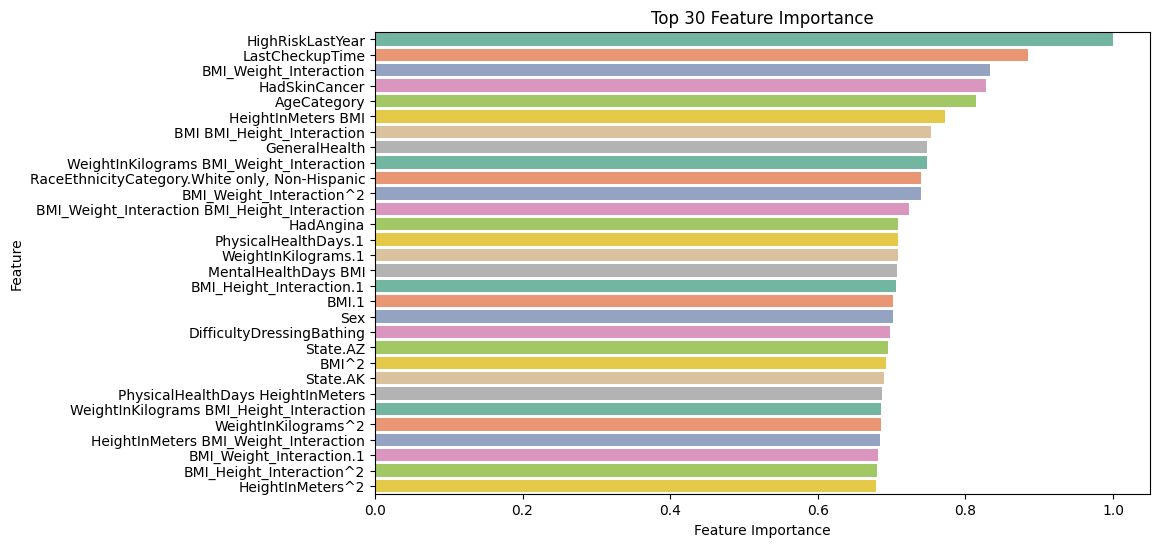

In [31]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=False)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')

# Show the plot
plt.show()


                              variable  raw_importance  scaled_importance  \
145  RaceEthnicityCategory.missing(NA)        0.000000           0.000000   
144                  State.missing(NA)        0.000000           0.000000   
143                  TetanusLast10Tdap        0.418204           0.418204   
142                       SmokerStatus        0.446695           0.446695   
141                        HadDiabetes        0.455267           0.455267   
..                                 ...             ...                ...   
4                          AgeCategory        0.813934           0.813934   
3                        HadSkinCancer        0.828113           0.828113   
2               BMI_Weight_Interaction        0.833900           0.833900   
1                      LastCheckupTime        0.885204           0.885204   
0                     HighRiskLastYear        1.000000           1.000000   

     relative_importance  
145             0.000000  
144             0.000

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_69507/2743676325.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


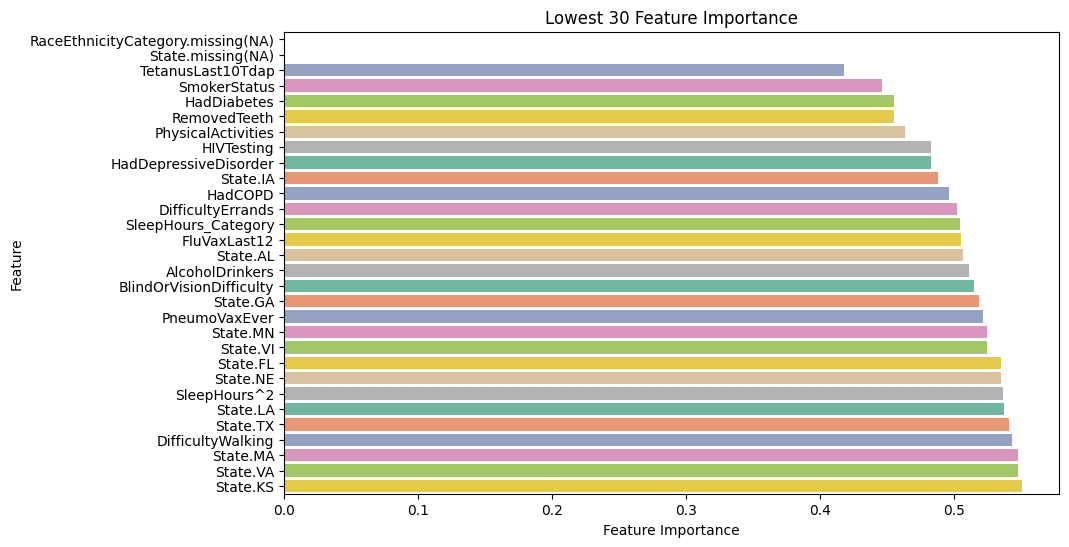

In [32]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=True)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Lowest 30 Feature Importance')

# Show the plot
plt.show()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


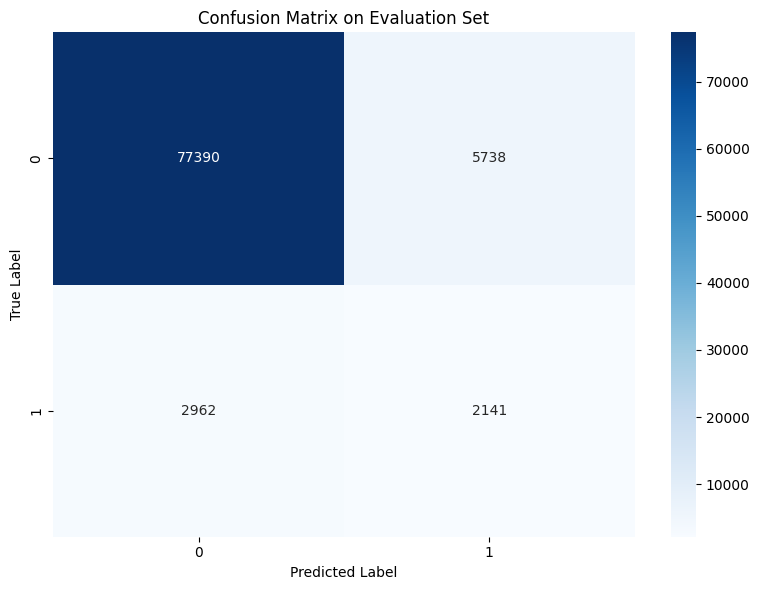

In [33]:
# Get the predictions from the best model (we assume the best model is already trained)
predictions = best_model.predict(test)

# Convert predictions to a pandas DataFrame for easier handling
predictions = predictions.as_data_frame()['predict']

# Get the true labels (actual values from the test set)
eval_labels = test['HadHeartAttack'].as_data_frame()['HadHeartAttack']

# Compute the confusion matrix
cm = confusion_matrix(eval_labels, predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(eval_labels),
            yticklabels=np.unique(eval_labels))

# Adding labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Evaluation Set")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Obective function: Recall

In [ ]:
# Train the AutoML model
aml = H2OAutoML(max_runtime_secs = 600, seed=42, sort_metric="recall")
aml.train(x=features, y=target, training_frame=train)

# Get the leaderboard of models
lb = aml.leaderboard
print(lb)

# Get the best model and evaluate it on the test set
best_model = aml.leader
predictions = best_model.predict(test)

# Evaluate model performance on the test set
performance = best_model.model_performance(test)
recall = performance.recall()

# Print Recall score for the best model
print(f"Best Model's Recall Score: {recall}")

AutoML progress: |
10:31:18.452: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                   recall       auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_AllModels_4_AutoML_1_20250514_103116            1  0.892329   0.149293  0.43987                 0.264467  0.20221   0.0408887
GBM_grid_1_AutoML_1_20250514_103116_model_2                     1  0.876947   0.159307  0.382847                0.282646  0.208496  0.0434704
GBM_grid_1_AutoML_1_20250514_103116_model_19                    1  0.891211   0.150844  0.427955                0.265882  0.203123  0.0412588
StackedEnsemble_AllModels_3_AutoML_1_20250514_103116            1  0.892286   0.149317  0.439897                0.264253  0.202204  0.0408863
GBM_1_AutoML_1_20250514_103116                                  1  0.882256   0.154368  0.41186                 0.26486   0.204965  

In [ ]:
# Get feature importance for the best model
feature_importance = best_model.varimp()

# Convert feature importance to pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance)

feature_importance_df 

None


Empty DataFrame
Columns: [variable, raw_importance, scaled_importance, relative_importance]
Index: []


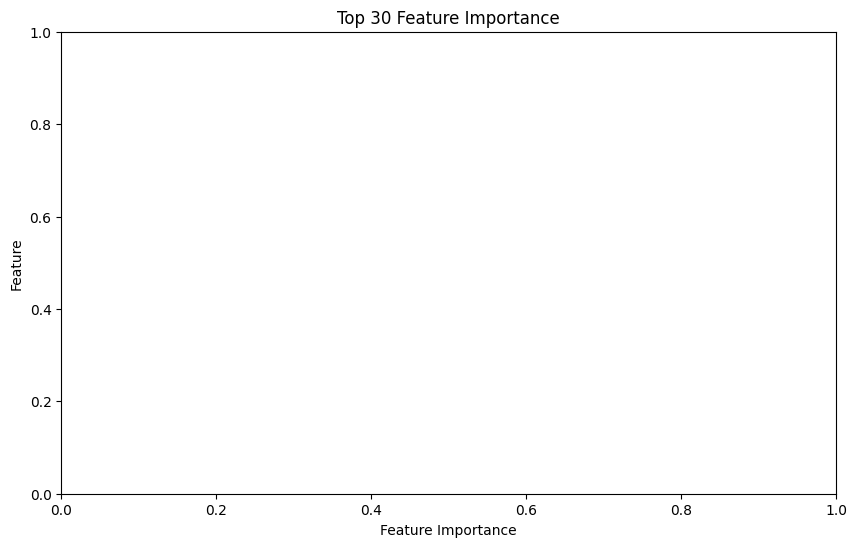

In [ ]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=False)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')

# Show the plot
plt.show()


Empty DataFrame
Columns: [variable, raw_importance, scaled_importance, relative_importance]
Index: []


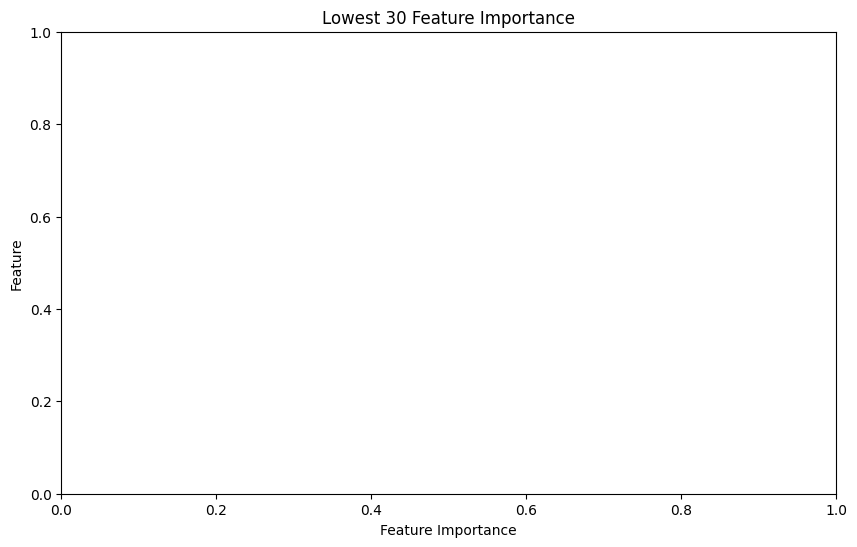

In [ ]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=True)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Lowest 30 Feature Importance')

# Show the plot
plt.show()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


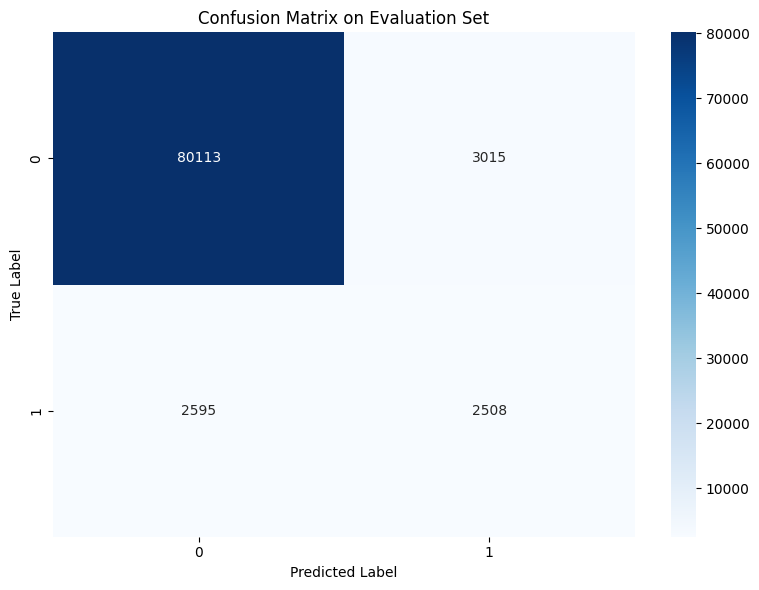

In [ ]:
# Get the predictions from the best model (we assume the best model is already trained)
predictions = best_model.predict(test)

# Convert predictions to a pandas DataFrame for easier handling
predictions = predictions.as_data_frame()['predict']

# Get the true labels (actual values from the test set)
eval_labels = test['HadHeartAttack'].as_data_frame()['HadHeartAttack']

# Compute the confusion matrix
cm = confusion_matrix(eval_labels, predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(eval_labels),
            yticklabels=np.unique(eval_labels))

# Adding labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Evaluation Set")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()